# COE Price Prediction and Quota Optimization Model

 
## Business Context
The Land Transport Authority (LTA) needs to better understand the relationship between 
COE quotas and prices to make informed policy decisions for price stabilization.
This model addresses three key policy questions:
1. Can we accurately predict COE prices across vehicle categories?
2. How sensitive are prices to quota adjustments?
3. What quota strategies can help stabilize volatile COE prices?

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

/opt/miniconda3/envs/coe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
sys.path.append("..")

from src.models import BaseModel, EnsembleModel
from src.utils import TemporalCrossValidator

## Data Sources for Policy Analysis

Historical COE bidding data provides the foundation for understanding price-quota dynamics.
This dataset contains all critical variables for policy simulation:

- Monthly quota allocations (policy lever)
- Actual bid prices (policy outcome) 
- Bidding activity levels (market demand proxy)

In [3]:
DATA_DIR = Path(os.getcwd()).parent / "data"
COE_BIDDING_PATH = DATA_DIR / "COEBiddingResultsPrices.csv"

In [4]:
original_df = pd.read_csv(COE_BIDDING_PATH)
original_df['month'] = pd.to_datetime(original_df['month'])

## Data Preprocessing For Policy Modeling

Remove 'bids_success' as it is a form of outcome data not available at policy decision time. Policy makers need to predict prices based on quota decisions, not bidding outcomes:

In [5]:
original_df.drop(columns=['bids_success'], inplace=True)

Clean numerical columns to ensure robust model training so that they can be ingested for modelling:

In [6]:
numerical_cols = ["bidding_no", "quota", "bids_received", "premium"]
for col in numerical_cols:
    original_df[col] = original_df[col].astype(str).str.replace(',', '').astype(int)

Create dummy variables for each COE category:

In [7]:
vehicle_class_dummies = pd.get_dummies(original_df['vehicle_class'], prefix='vehicle_class')
original_df = pd.concat([original_df, vehicle_class_dummies], axis=1)
original_df.drop('vehicle_class', axis=1, inplace=True)

Rename columns for Prophet time series modeling. Prophet is chosen for its ability to handle volatility and seasonality in COE prices:

In [8]:
original_df = original_df.rename(columns={'month': 'ds', 'premium': 'y'})

In [9]:
print(f"Policy analysis data range: {original_df['ds'].min().date()} to {original_df['ds'].max().date()}")
print(f"Total bidding records: {len(original_df)} (spanning {len(original_df)//60:.1f} years of monthly data)")

Policy analysis data range: 2010-01-01 to 2025-07-01
Total bidding records: 1840 (spanning 30.0 years of monthly data)


## Cross-Validation with Sliding Windows

We use sliding window cross-validation to evaluate model performance over time:
- Training window: 1 year of data to capture recent market dynamics
- Test window: 3 months ahead to match policy planning cycles  
- Slide forward: Move windows by 3 months to simulate continuous model updates

This approach:
1. Preserves temporal order of data
2. Simulates real-world policy deployment scenarios, where we periodically retrain and redeploy the model


In [10]:
cv = TemporalCrossValidator(
    initial_train_years=1,        # Balance between data volume and recency for volatile markets
    test_period_months=3,         # Matches quarterly policy planning horizon
    step_months=3,               # Continuous model updates as new data becomes available
)

# Generate time splits for rigorous policy validation
splits = cv.get_time_splits(original_df)
print(f"\\nPOLICY VALIDATION FRAMEWORK:")
print(f"Generated {len(splits)} validation periods simulating real-world deployment")
print(f"Training window: {cv.initial_train_years} year (captures recent market dynamics)")
print(f"Prediction horizon: {cv.test_period_months} months (quarterly policy cycles)")
print(f"Model update frequency: Every {cv.step_months} months")
print()
print("Validation Timeline (simulating historical policy decisions):")
print("-" * 80)

for split in splits:
    print(f"  Period {split['fold']:2d}: Train {split['train_start'].strftime('%Y-%m')} to {split['train_end'].strftime('%Y-%m')} "
          f"→ Predict {split['test_start'].strftime('%Y-%m')} to {split['test_end'].strftime('%Y-%m')} "
          f"({split['train_size']:3d} samples → {split['test_size']:2d} predictions)")

\nPOLICY VALIDATION FRAMEWORK:
Generated 53 validation periods simulating real-world deployment
Training window: 1 year (captures recent market dynamics)
Prediction horizon: 3 months (quarterly policy cycles)
Model update frequency: Every 3 months

Validation Timeline (simulating historical policy decisions):
--------------------------------------------------------------------------------
  Period  1: Train 2010-01 to 2010-12 → Predict 2011-01 to 2011-03 (120 samples → 30 predictions)
  Period  2: Train 2010-04 to 2011-03 → Predict 2011-04 to 2011-06 (120 samples → 30 predictions)
  Period  3: Train 2010-07 to 2011-06 → Predict 2011-07 to 2011-09 (120 samples → 30 predictions)
  Period  4: Train 2010-10 to 2011-09 → Predict 2011-10 to 2011-12 (120 samples → 30 predictions)
  Period  5: Train 2011-01 to 2011-12 → Predict 2012-01 to 2012-03 (120 samples → 30 predictions)
  Period  6: Train 2011-04 to 2012-03 → Predict 2012-04 to 2012-06 (120 samples → 30 predictions)
  Period  7: Train 2

The model is an ensemble of five smaller Prophet base models, one for each COE category. Depending on the input data, the model dynamically routes prediction tasks to the appropraite base model:

In [11]:
# Define model function for temporal CV
def ensemble_model_func(train_df, test_df):
    """
    Model function for temporal CV evaluation
    Takes train and test dataframes, returns predictions
    """
    # Standardize features (quota and bids_received)
    scaler = StandardScaler()
    cols_to_scale = ['quota', 'bids_received']
    
    # Fit scaler on train data only
    train_scaled = train_df.copy()
    test_scaled = test_df.copy()
    
    train_scaled[cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale].astype(float))
    test_scaled[cols_to_scale] = scaler.transform(test_df[cols_to_scale].astype(float))
    
    # Create and fit ensemble model
    vehicle_classes = ['Category A', 'Category B', 'Category C', 'Category D', 'Category E']
    regressors = ['bidding_no', 'quota', 'bids_received']
    
    model = EnsembleModel(vehicle_classes, regressors)
    model.fit(train_scaled)
    
    # Get predictions
    predictions = model.predict(test_scaled)
    
    return predictions


In [8]:
# Run temporal cross validation
print("Running Temporal Cross Validation...")
print("This may take several minutes as each fold trains 5 Prophet models...")

cv_results = cv.evaluate_model(ensemble_model_func, splits, verbose=False)

15:15:01 - cmdstanpy - INFO - Chain [1] start processing
15:15:01 - cmdstanpy - INFO - Chain [1] done processing
15:15:01 - cmdstanpy - INFO - Chain [1] start processing
15:15:01 - cmdstanpy - INFO - Chain [1] done processing
15:15:01 - cmdstanpy - INFO - Chain [1] start processing


Running Temporal Cross Validation...
This may take several minutes as each fold trains 5 Prophet models...
Fitting base models


15:15:01 - cmdstanpy - INFO - Chain [1] done processing
15:15:01 - cmdstanpy - INFO - Chain [1] start processing
15:15:01 - cmdstanpy - INFO - Chain [1] done processing
15:15:01 - cmdstanpy - INFO - Chain [1] start processing
15:15:01 - cmdstanpy - INFO - Chain [1] done processing
15:15:01 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing


Fitting base models


15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing


Fitting base models


15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing


Fitting base models


15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing


Fitting base models


15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing


Fitting base models


15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:12 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:12 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing


Fitting base models


15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:18 - cmdstanpy - INFO - Chain [1] done processing
15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:18 - cmdstanpy - INFO - Chain [1] done processing


Fitting base models


15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:18 - cmdstanpy - INFO - Chain [1] done processing
15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:18 - cmdstanpy - INFO - Chain [1] done processing
15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:18 - cmdstanpy - INFO - Chain [1] done processing
15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:18 - cmdstanpy - INFO - Chain [1] done processing
15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:18 - cmdstanpy - INFO - Chain [1] done processing
15:15:18 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:18 - cmdstanpy - INFO - Chain [1] done processing


\n============================================================
DETAILED TEMPORAL CROSS VALIDATION ANALYSIS


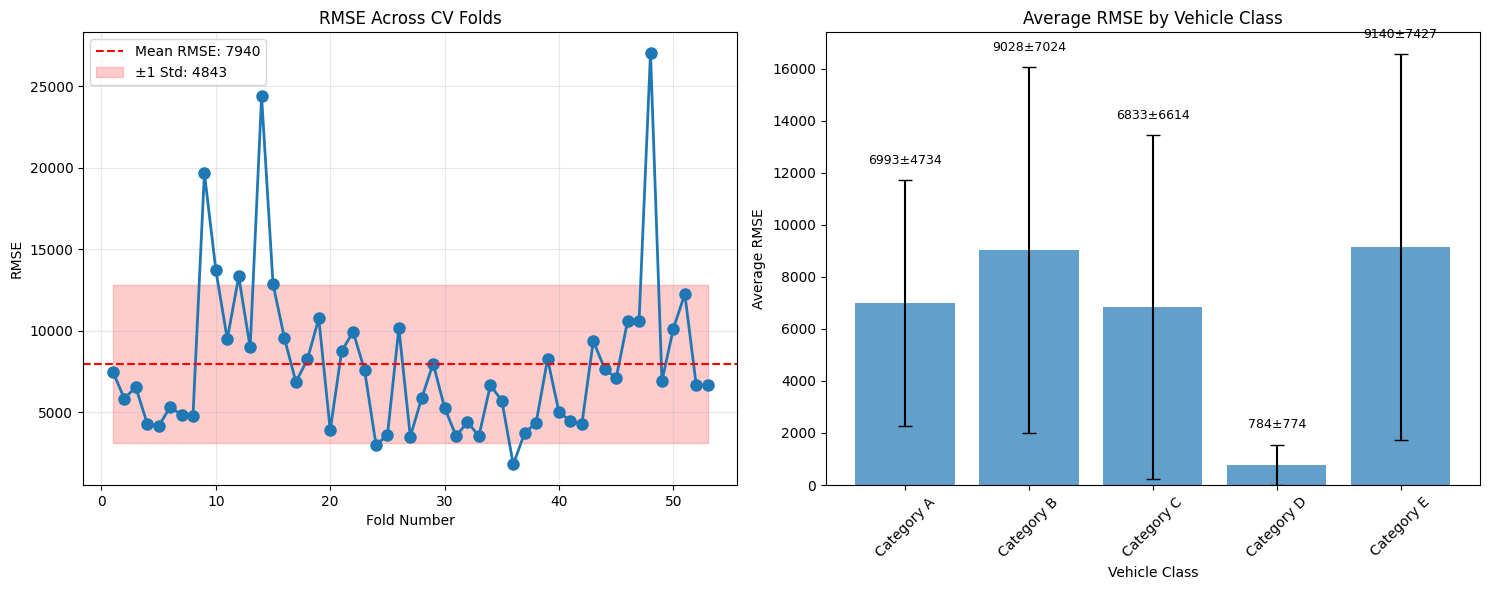

\nFold-by-fold breakdown:
--------------------------------------------------------------------------------
Fold   Test Period               RMSE       Train Size   Test Size 
--------------------------------------------------------------------------------
1      2011-01-01 to 2011-03-01  7475       120          30        
2      2011-04-01 to 2011-06-01  5830       120          30        
3      2011-07-01 to 2011-09-01  6532       120          30        
4      2011-10-01 to 2011-12-01  4287       120          30        
5      2012-01-01 to 2012-03-01  4144       120          30        
6      2012-04-01 to 2012-06-01  5292       120          30        
7      2012-07-01 to 2012-09-01  4839       120          30        
8      2012-10-01 to 2012-12-01  4755       120          30        
9      2013-01-01 to 2013-03-01  19678      120          30        
10     2013-04-01 to 2013-06-01  13716      120          30        
11     2013-07-01 to 2013-09-01  9478       120          30     

In [9]:
# Analyze and visualize CV results
print("\\n" + "="*60)
print("DETAILED TEMPORAL CROSS VALIDATION ANALYSIS")
print("="*60)

# Extract fold-wise results for visualization
fold_numbers = [r['fold'] for r in cv_results['fold_results']]
fold_rmses = [r['rmse'] for r in cv_results['fold_results']]

# Create visualization of CV results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: RMSE by fold
ax1.plot(fold_numbers, fold_rmses, 'o-', linewidth=2, markersize=8)
ax1.axhline(y=cv_results['mean_rmse'], color='red', linestyle='--', 
            label=f'Mean RMSE: {cv_results["mean_rmse"]:.0f}')
ax1.fill_between(fold_numbers, 
                    cv_results['mean_rmse'] - cv_results['std_rmse'],
                    cv_results['mean_rmse'] + cv_results['std_rmse'],
                    alpha=0.2, color='red', label=f'±1 Std: {cv_results["std_rmse"]:.0f}')
ax1.set_xlabel('Fold Number')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE Across CV Folds')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Vehicle class performance comparison
vehicle_stats = cv_results['avg_vehicle_rmses']
if vehicle_stats:
    vehicles = list(vehicle_stats.keys())
    means = [vehicle_stats[v]['mean'] for v in vehicles]
    stds = [vehicle_stats[v]['std'] for v in vehicles]
    
    bars = ax2.bar(vehicles, means, yerr=stds, capsize=5, alpha=0.7)
    ax2.set_xlabel('Vehicle Class')
    ax2.set_ylabel('Average RMSE')
    ax2.set_title('Average RMSE by Vehicle Class')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + std + 500,
                    f'{mean:.0f}±{std:.0f}',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print detailed fold-by-fold breakdown
print("\\nFold-by-fold breakdown:")
print("-" * 80)
print(f"{'Fold':<6} {'Test Period':<25} {'RMSE':<10} {'Train Size':<12} {'Test Size':<10}")
print("-" * 80)

for result in cv_results['fold_results']:
    print(f"{result['fold']:<6} {result['test_period']:<25} "
            f"{result['rmse']:<10.0f} {result['train_size']:<12} {result['test_size']:<10}")

# Compare with single holdout validation
print(f"\\n{'='*60}")
print("COMPARISON WITH SINGLE HOLDOUT VALIDATION")
print(f"{'='*60}")
print(f"Temporal CV Average RMSE: {cv_results['mean_rmse']:.0f} ± {cv_results['std_rmse']:.0f}")

Considering the highly volatile nature of COE prices, the ensemble model produces reasonable predictions. Considering current Category A and B COE prices of around $100k, the RMSE is <8% of the actual COE price.

Next, we do a final prediction for the most recent data:

In [10]:
def evaluate_on_vehicle_classes(model, df):
    predictions = model.predict(df)

    # Calculate RMSE for each vehicle class
    vehicle_classes = ['Category A', 'Category B', 'Category C', 'Category D', 'Category E']
    rmses = {}
    for vehicle_class in vehicle_classes:
        # Filter test data and predictions for this vehicle class
        mask = df[f'vehicle_class_{vehicle_class}'] == True
        class_df = df[mask]
        class_pred = predictions[mask]
        
        # Calculate RMSE if there are samples for this class
        if len(class_df) > 0:
            rmses[vehicle_class] = root_mean_squared_error(class_df['y'], class_pred['yhat'])

    # Calculate overall RMSE
    rmses["Overall"] = root_mean_squared_error(df['y'], predictions['yhat'])
    return rmses

In [11]:
# Fit model for the last split
last_split = splits[-1]
train_df = last_split['train_df']
test_df = last_split['test_df']

# Train ensemble model on the final split
vehicle_classes = ['Category A', 'Category B', 'Category C', 'Category D', 'Category E']
regressors = ['bidding_no', 'quota', 'bids_received']
ensemble_model = EnsembleModel(vehicle_classes, regressors)
ensemble_model.fit(train_df)

# Get predictions
predictions = ensemble_model.predict(test_df)
test_rmses = evaluate_on_vehicle_classes(ensemble_model, test_df)

print(f"\nFinal Split Performance:")
print(f"Train period: {last_split['train_start'].date()} to {last_split['train_end'].date()}")
print(f"Test period: {last_split['test_start'].date()} to {last_split['test_end'].date()}")

test_rmses

15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:18 - cmdstanpy - INFO - Chain [1] done processing
15:15:18 - cmdstanpy - INFO - Chain [1] start processing


Fitting base models


15:15:18 - cmdstanpy - INFO - Chain [1] done processing
15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:18 - cmdstanpy - INFO - Chain [1] done processing
15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:18 - cmdstanpy - INFO - Chain [1] done processing
15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:18 - cmdstanpy - INFO - Chain [1] done processing



Final Split Performance:
Train period: 2024-04-01 to 2025-03-01
Test period: 2025-04-01 to 2025-06-01


{'Category A': 13983.504742800775,
 'Category B': 4157.860362552385,
 'Category C': 2014.7867714557915,
 'Category D': 780.6877533401071,
 'Category E': 1650.3824857157354,
 'Overall': 6636.547432787951}

## Effect of COE Quota on Price

### Policy Simulation Framework for Quota Sensitivity Analysis

To understand how quota adjustments impact COE prices, we implement a controlled simulation approach that isolates the quota effect while holding other market factors constant. This methodology directly addresses LTA's need to predict price outcomes from policy interventions.

### Simulation Design

**Quota Range Selection**: We test quotas from 100 to 1,000 certificates per bidding exercise

**Control Variables**: For each vehicle category, we create standardized scenarios using:
- **Average bidding number**: Controls for time trend effects
- **Average bids received**: Standardizes demand proxy across scenarios
- **Fixed prediction date**: April 2025 (recent training data context)

This approach ensures that quota is the primary variable driving price changes, enabling clean policy impact measurement.


Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted to DataFrame
Input was a Series - converted t

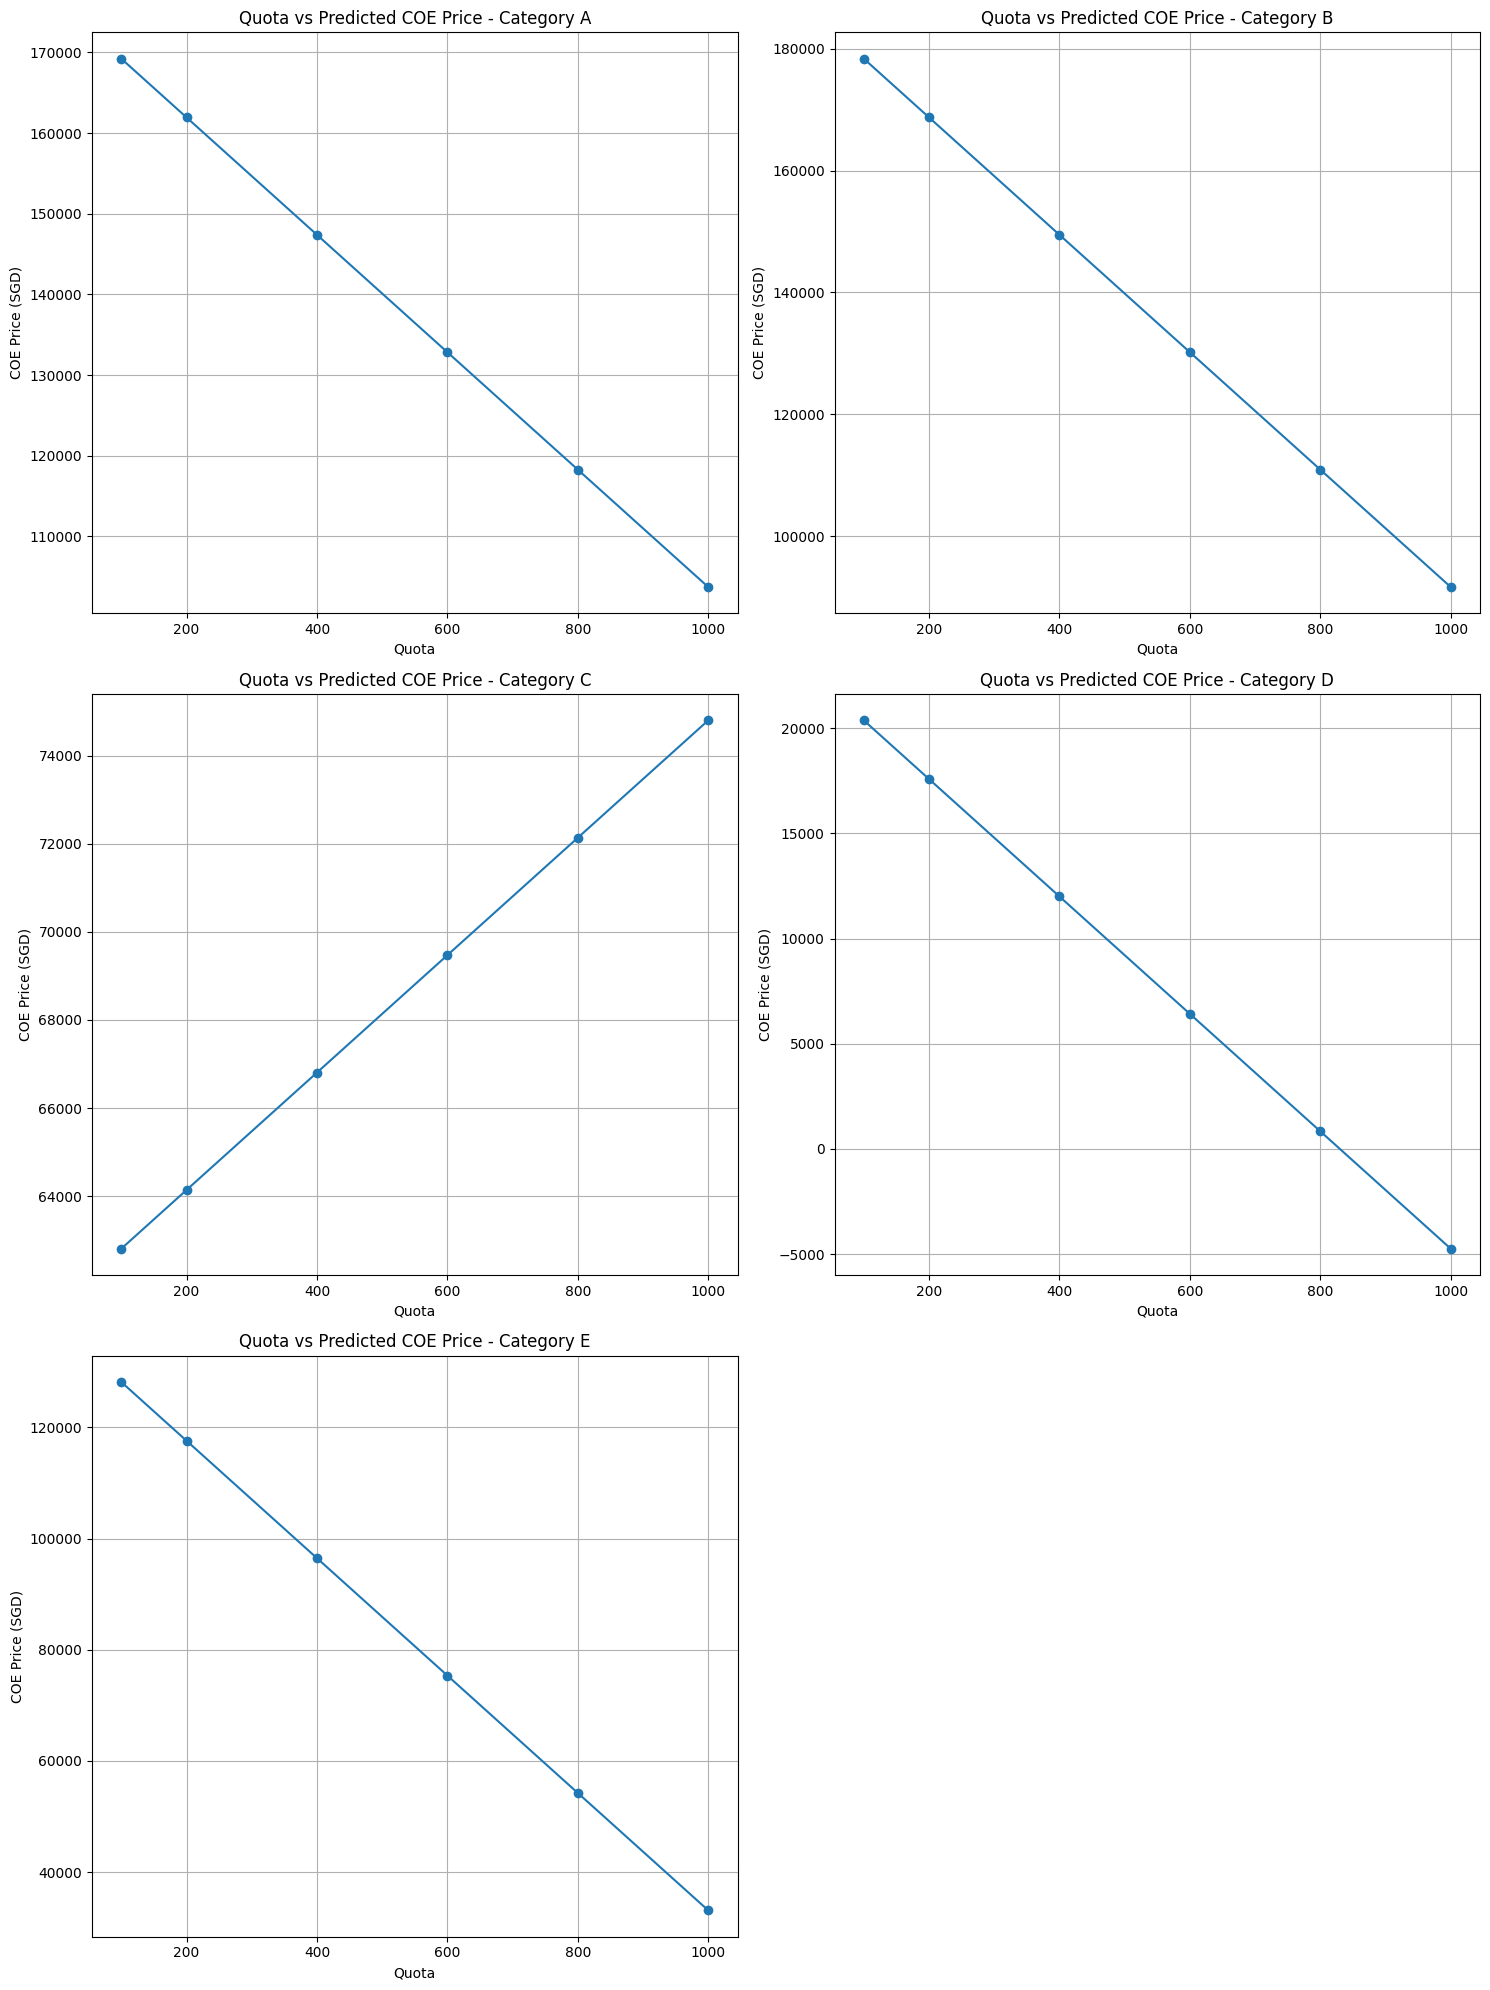

In [16]:
quota_values = [100, 200, 400, 600, 800, 1000]
vehicle_classes = ['Category A', 'Category B', 'Category C', 'Category D', 'Category E']

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.flatten()

# Loop through each vehicle class
for i, vehicle_class in enumerate(vehicle_classes):
    yhats = []
    
    # Create dummy dataset using averages from this vehicle class
    dummy_df = test_df.copy()
    dummy_df = dummy_df[dummy_df[f'vehicle_class_{vehicle_class}'] == True]
    dummy_df['bidding_no'] = dummy_df['bidding_no'].mean().round()
    dummy_df['quota'] = dummy_df['quota'].mean().round() 
    dummy_df['bids_received'] = dummy_df['bids_received'].mean().round()
    dummy_df = dummy_df.drop('y', axis=1)
    dummy_df = dummy_df.iloc[0]
    dummy_df['ds'] = '2025-04-01'

    # Get predictions for different quota values
    for quota in quota_values:
        dummy_df['quota'] = quota
        yhats.append(ensemble_model.predict(dummy_df)["yhat"])

    # Plot in corresponding subplot
    axes[i].plot(quota_values, yhats, marker='o')
    axes[i].set_xlabel('Quota')
    axes[i].set_ylabel('COE Price (SGD)')
    axes[i].set_title(f'Quota vs Predicted COE Price - {vehicle_class}')
    axes[i].grid(True)

# Remove the empty subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

Conclusions:
- Increasing quota for decreases price for all COE categories except Category C (Goods Vehicles and Buses)
- One possible reason is that the increase in quota results in more competitive and aggressive bids within the categories
- While increasing quota might seem like an obvious way to bring down COE prices for more categories, it is not a practical solution as the resulting increase in number of vehicles will lead to congestion


### Interpretation of Results

**Category A, B, D and E**:
- Strong negative correlation between quota and price
- Private car buyers are price-sensitive and can defer purchase
- While these are clear targets for quota-based COE stabilisation, rapid quota expansions may risk an excess number of vehicles on the road, leading to congestion

**Category C (Commercial Vehicles - Goods & Buses)**:
- ANOMALOUS - Price may increase with higher quotas
- Companies may increase vehicle investments when quotas signal policy support
- Commercial bidders may bid more aggressively when quota availability increases